# Text-based NB and SVM on Reddit Threads Data

Rui Qiu (rq47)
2021-11-21

Cleaning script can be found at [reddit-scraper-v2.R](reddit-scraper-v2.R).

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC

reddit = pd.read_csv("../data/nba-reddit/nba-top-100-threads-this-year-cleaned.csv")
reddit

,title,upvote_ratio
0,Draymond Green on last night's Capitol breach:...,top rated
1,"[Jaylen Brown] “In one America, you get killed...",top rated
2,[Scipioni] NBA legend Charles Barkley: ‘The on...,somewhat top rated
3,Giannis orders 50 chicken nuggets on IG live a...,somewhat top rated
4,"Doc Rivers: “I will say it, because I don’t th...",top rated
...,...,...
95,[Highlight] Fan ejected for pouring popcorn at...,very top rated
96,"[Highlight] Kenny Smith: ""Hakeem Olajuwon used...",highly top rated
97,[Highlight] Paul George tries to pass it to th...,somewhat top rated
98,Enes Kanter doubles down on China and calls Xi...,very top rated


In [2]:
replace = [
    (r"<a[^>]*>(.*?)</a>", r"\1"),  # Matches most URLs
    (r"(?<=\d),(?=\d)", ""),        # Remove commas in numbers
    (r"\d+", "numbr"),              # Map digits to special token <numbr>
    (r"[\t\n\r\*\.\@\,\-\/\_\(\)\:\[\]\"\'\‘\`\“\”\?\’\$]", " "),   # Punctuation and other junk
    (r"\s+", " "),                   # Strips extra whitespace
    (r"^\s+", "")
]

for repl in replace:
    reddit['title'] = [re.sub(repl[0], repl[1], text) for text in reddit['title']]

reddit['title'] = reddit['title'].str.lower()
reddit['rank'] = np.arange(len(reddit))
reddit['popularity'] = np.where(reddit['rank'] <= 49, 'Extremely Popular', 'Very Popular')

reddit

,title,upvote_ratio,rank,popularity
0,draymond green on last night s capitol breach ...,top rated,0,Extremely Popular
1,jaylen brown in one america you get killed by ...,top rated,1,Extremely Popular
2,scipioni nba legend charles barkley the only p...,somewhat top rated,2,Extremely Popular
3,giannis orders numbr chicken nuggets on ig liv...,somewhat top rated,3,Extremely Popular
4,doc rivers i will say it because i don t think...,top rated,4,Extremely Popular
...,...,...,...,...
95,highlight fan ejected for pouring popcorn at w...,very top rated,95,Very Popular
96,highlight kenny smith hakeem olajuwon used to ...,highly top rated,96,Very Popular
97,highlight paul george tries to pass it to the ...,somewhat top rated,97,Very Popular
98,enes kanter doubles down on china and calls xi...,very top rated,98,Very Popular


In [3]:
my_stop_words = text.ENGLISH_STOP_WORDS.union(['t', 'p', 's', 'f', 'w'])

vec_tfidf = TfidfVectorizer(input='title', stop_words=my_stop_words, ngram_range=(1, 2), max_features=500)
dtm = vec_tfidf.fit_transform(reddit['title'])
col_names = vec_tfidf.get_feature_names()
df = pd.DataFrame(dtm.toarray(), columns=col_names)
df['popularity'] = reddit['popularity']
df

/Users/rqiu/anaconda3/envs/anly-580/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,accounts,actually,agreed,agreed trade,ain,ali,america,amp,angeles,angeles lakers,...,wizards,wojnarowski,won,work,world,year,years,уou,уou think,popularity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Extremely Popular
1,0.0,0.0,0.0,0.0,0.0,0.0,0.67226,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Extremely Popular
2,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Extremely Popular
3,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Extremely Popular
4,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Extremely Popular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Very Popular
96,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Very Popular
97,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Very Popular
98,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Very Popular


In [4]:
pd.DataFrame.to_csv(df, 'reddit-unigram-tfidf.csv')

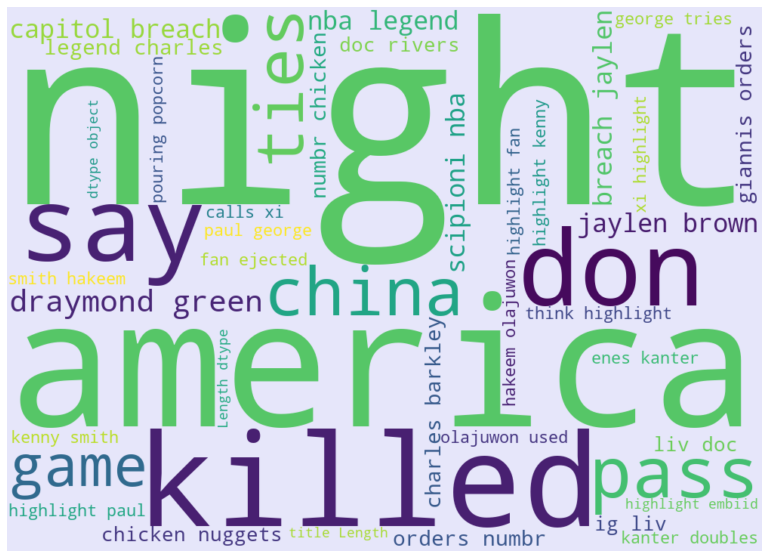

In [5]:
plt.figure(figsize=(15, 10))
wordcloud = WordCloud(background_color='lavender',
                        width=1000, height=720,
                        random_state=42, stopwords=my_stop_words,
                        font_step=2,
                        max_words=100,
                        collocation_threshold = 2,
                        max_font_size=500).generate(str(reddit['title']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('reddit-title-wordcloud2.png')

In [6]:
# splitting

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'popularity'], df['popularity'], test_size=0.2, random_state=42, stratify=df['popularity'])

# feature scaling

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## naive Bayes

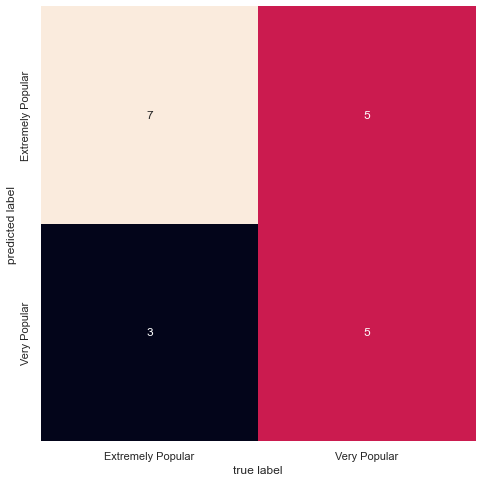

In [7]:
nb_model = make_pipeline(MultinomialNB(alpha=0.1))
# nb_model = make_pipeline(GaussianNB())
nb_model.fit(X_train, y_train)
nb_labels = nb_model.predict(X_test)

mat = confusion_matrix(y_test, nb_labels, labels=['Extremely Popular', 'Very Popular'])

plt.figure(figsize=(10, 8))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Extremely Popular', 'Very Popular'],
            yticklabels=['Extremely Popular', 'Very Popular'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig('reddit-nb-cm.png')

In [8]:
print(classification_report(y_test, nb_labels))

                   precision    recall  f1-score   support

Extremely Popular       0.58      0.70      0.64        10
     Very Popular       0.62      0.50      0.56        10

         accuracy                           0.60        20
        macro avg       0.60      0.60      0.60        20
     weighted avg       0.60      0.60      0.60        20



In [9]:
y_predicted = nb_model.predict_proba(X_test)
y_predicted[:,0]

array([0.73591504, 0.61425358, 0.81277636, 0.23132551, 0.18811656,
       0.84113802, 0.93288234, 0.90881548, 0.88082318, 0.73184191,
       0.86555296, 0.47794011, 0.7181615 , 0.52883666, 0.23558142,
       0.39114991, 0.13502387, 0.46222709, 0.58620645, 0.45716074])

In [10]:
nb_labels

array(['Extremely Popular', 'Extremely Popular', 'Extremely Popular',
       'Very Popular', 'Very Popular', 'Extremely Popular',
       'Extremely Popular', 'Extremely Popular', 'Extremely Popular',
       'Extremely Popular', 'Extremely Popular', 'Very Popular',
       'Extremely Popular', 'Extremely Popular', 'Very Popular',
       'Very Popular', 'Very Popular', 'Very Popular',
       'Extremely Popular', 'Very Popular'], dtype='<U17')

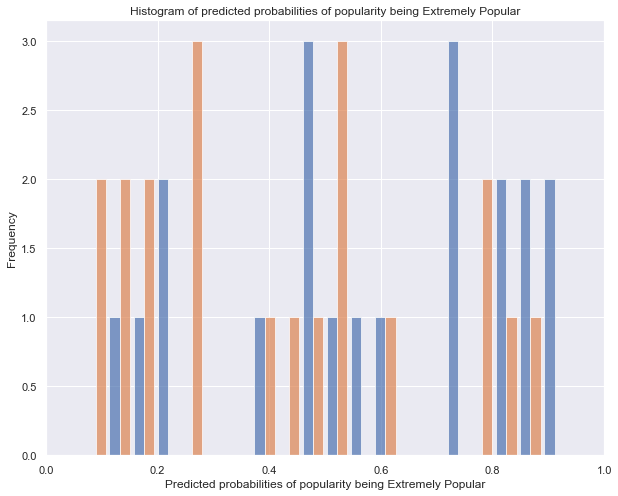

In [11]:
# histogram
plt.figure(figsize=(10, 8))
plt.rcParams['font.size'] = 12
plt.hist(y_predicted, bins=20, alpha=0.7, rwidth=0.85)
plt.title('Histogram of predicted probabilities of popularity being Extremely Popular')
plt.xlim(0, 1)
plt.xlabel('Predicted probabilities of popularity being Extremely Popular')
plt.ylabel('Frequency')

# orange is extremely popular, blue is very popular
plt.savefig('reddit-nb-prediction-hist.png')

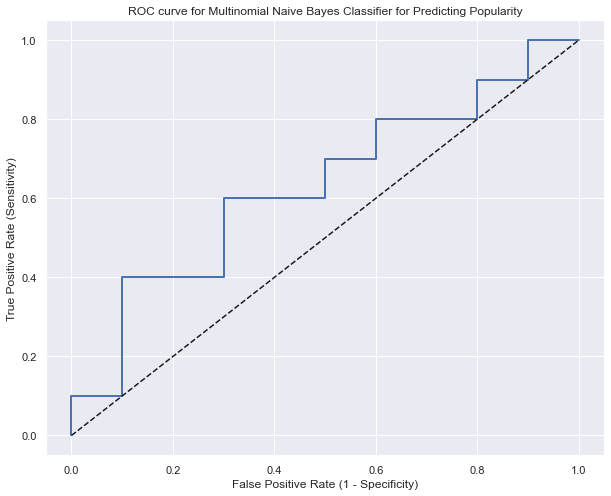

In [12]:
fpr, tpr, threshold= roc_curve(y_test, y_predicted[:,0], pos_label = 'Extremely Popular')
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Multinomial Naive Bayes Classifier for Predicting Popularity')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.savefig('reddit-nb-roc.png')

## SVM

In [13]:
C_param_range = [0.01, 0.1, 1, 10, 100]

svm_linear_table = pd.DataFrame(columns=['C', 'Accuracy'])
svm_linear_table['C'] = C_param_range

j = 0

for i in C_param_range:
    svm_linear = SVC(C=i, kernel='linear', random_state=42)
    svm_linear.fit(X_train, y_train)
    svm_linear_pred = svm_linear.predict(X_test)
    svm_linear_table.iloc[j, 1] = accuracy_score(y_test, svm_linear_pred)
    j += 1

print(svm_linear_table)

        C Accuracy
0    0.01     0.45
1    0.10     0.45
2    1.00      0.6
3   10.00      0.6
4  100.00      0.6


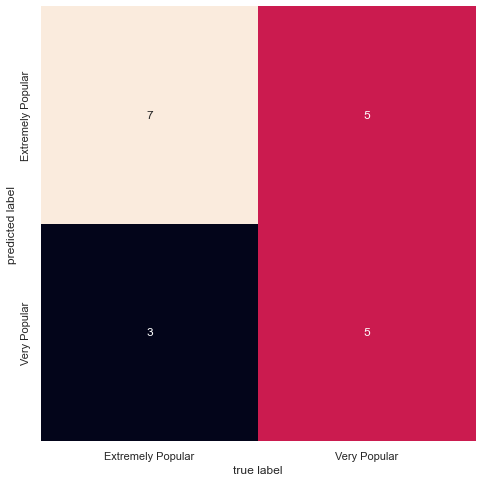

In [14]:
svm_linear_model = SVC(C=1, kernel='linear', random_state=42)
svm_linear_model.fit(X_train, y_train)
svm_linear_model_pred = svm_linear_model.predict(X_test)

mat = confusion_matrix(y_test, svm_linear_model_pred, labels=['Extremely Popular', 'Very Popular'])

plt.figure(figsize=(10, 8))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Extremely Popular', 'Very Popular'],
            yticklabels=['Extremely Popular', 'Very Popular'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig('reddit-svm-linear-cm.png')

In [15]:
print(classification_report(y_test, svm_linear_model_pred))

                   precision    recall  f1-score   support

Extremely Popular       0.58      0.70      0.64        10
     Very Popular       0.62      0.50      0.56        10

         accuracy                           0.60        20
        macro avg       0.60      0.60      0.60        20
     weighted avg       0.60      0.60      0.60        20



In [16]:
poly_degree_range = [1, 2, 3, 4, 5, 6]

svm_poly_table = pd.DataFrame(columns=['degree', 'Accuracy'])
svm_poly_table['degree'] = poly_degree_range

j = 0

for i in poly_degree_range:
    svm_poly = SVC(C=1, kernel='poly', degree = i, random_state=42)
    svm_poly.fit(X_train, y_train)
    svm_poly_pred = svm_poly.predict(X_test)
    svm_poly_table.iloc[j, 1] = accuracy_score(y_test, svm_poly_pred)
    j += 1

print(svm_poly_table)

   degree Accuracy
0       1      0.5
1       2     0.45
2       3      0.5
3       4      0.5
4       5      0.5
5       6      0.5


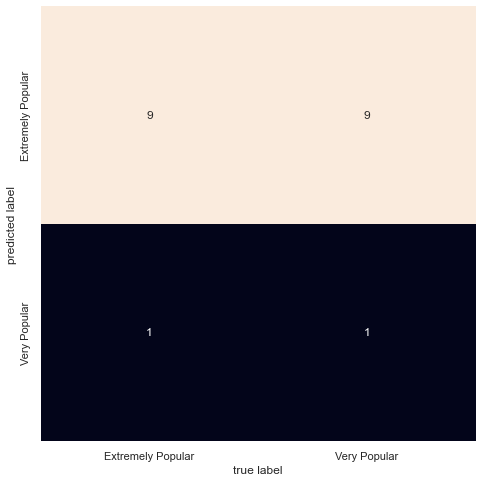

In [17]:
svm_poly_model = SVC(C=1, degree=1, kernel='poly', random_state=42)
svm_poly_model.fit(X_train, y_train)
svm_poly_model_pred = svm_poly_model.predict(X_test)

mat = confusion_matrix(y_test, svm_poly_model_pred, labels=['Extremely Popular', 'Very Popular'])

plt.figure(figsize=(10, 8))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Extremely Popular', 'Very Popular'],
            yticklabels=['Extremely Popular', 'Very Popular'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig('reddit-svm-poly-cm.png')

In [18]:
print(classification_report(y_test, svm_poly_model_pred))

                   precision    recall  f1-score   support

Extremely Popular       0.50      0.90      0.64        10
     Very Popular       0.50      0.10      0.17        10

         accuracy                           0.50        20
        macro avg       0.50      0.50      0.40        20
     weighted avg       0.50      0.50      0.40        20



In [19]:
rbf_degree_range = [1, 2, 3, 4, 5, 6]

svm_rbf_table = pd.DataFrame(columns=['degree', 'Accuracy'])
svm_rbf_table['degree'] = rbf_degree_range

j = 0

for i in rbf_degree_range:
    svm_rbf = SVC(C=1, kernel='rbf', degree = i, random_state=42)
    svm_rbf.fit(X_train, y_train)
    svm_rbf_pred = svm_rbf.predict(X_test)
    svm_rbf_table.iloc[j, 1] = accuracy_score(y_test, svm_rbf_pred)
    j += 1

print(svm_rbf_table)

   degree Accuracy
0       1      0.5
1       2      0.5
2       3      0.5
3       4      0.5
4       5      0.5
5       6      0.5


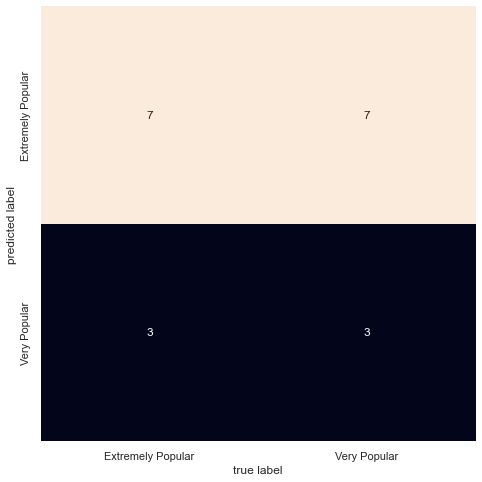

In [20]:
svm_rbf_model = SVC(C=1, degree=1, kernel='rbf', random_state=42)
svm_rbf_model.fit(X_train, y_train)
svm_rbf_model_pred = svm_rbf_model.predict(X_test)

mat = confusion_matrix(y_test, svm_rbf_model_pred, labels=['Extremely Popular', 'Very Popular'])

plt.figure(figsize=(10, 8))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Extremely Popular', 'Very Popular'],
            yticklabels=['Extremely Popular', 'Very Popular'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig('reddit-svm-rbf-cm.png')

In [21]:
print(classification_report(y_test, svm_rbf_model_pred))

                   precision    recall  f1-score   support

Extremely Popular       0.50      0.70      0.58        10
     Very Popular       0.50      0.30      0.37        10

         accuracy                           0.50        20
        macro avg       0.50      0.50      0.48        20
     weighted avg       0.50      0.50      0.48        20

